In [1]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras import optimizers
import keras.backend as K
from keras.applications import VGG16
from keras.preprocessing import image
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2

Using TensorFlow backend.


In [2]:
original_dataset_dir = '\\Users\\Hazem\\Desktop\\Dataset\\train'
base_dir = '/Users/Hazem/Desktop/Dataset/small_cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [3]:
print('Total training cat images: ', len(os.listdir(train_cats_dir)))
print('Total training dog images: ', len(os.listdir(train_dogs_dir)))

Total training cat images:  1000
Total training dog images:  1000


In [6]:
#Pretrained Network using feature extraction
conv_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()
batch_size = 20

def extract_features(directory, sample_count):
    datagen = image.ImageDataGenerator(rescale=1./255)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
            directory,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

(2000, 8192)


In [12]:
print(train_features.shape)

(2000, 8192)


In [13]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

W0802 12:00:29.747509  4172 deprecation.py:506] From C:\Users\Hazem\Anaconda3\envs\venv\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_features, train_labels,epochs=30,batch_size=20,validation_data=(validation_features, validation_labels))
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

W0802 12:01:13.722370  4172 deprecation_wrapper.py:119] From C:\Users\Hazem\Anaconda3\envs\venv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0802 12:01:13.733361  4172 deprecation.py:323] From C:\Users\Hazem\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6028 - acc: 0.6780 - val_loss: 0.4365 - val_acc: 0.8270
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4261 - acc: 0.8010 - val_loss: 0.3558 - val_acc: 0.8720
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3582 - acc: 0.8510 - val_loss: 0.3191 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3250 - acc: 0.8620 - val_loss: 0.2990 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2836 - acc: 0.8860 - val_loss: 0.2811 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2615 - acc: 0.8920 - val_loss: 0.2716 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2488 - acc: 0.8910 - val_loss: 0.2644 - val_acc: 0.8920
Epoch 8/30
200

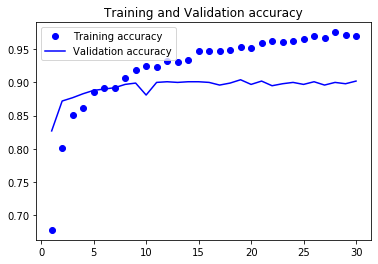

In [15]:
#Plotting training and validation accuracy
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

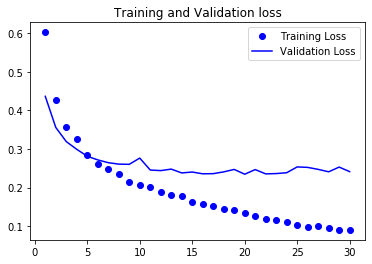

In [16]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()